Specifying tensor flow version

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Download yacra repository

In [ ]:
!git clone https://github.com/mrezende/concra.git

Cloning into 'concra'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 1356 (delta 1), reused 7 (delta 1), pack-reused 1341
Receiving objects: 100% (1356/1356), 3.57 GiB | 34.99 MiB/s, done.
Resolving deltas: 100% (878/878), done.
Checking out files: 100% (796/796), done.


Go to yacra folder

In [ ]:
%cd /content/concra

/content/concra


Get question title and code snippet


In [ ]:
import matplotlib
import pickle
import sys
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import json
from gensim.models import Word2Vec
import random
import numpy as np
import os
from data_processing.code_processing import *
from keras.preprocessing.text import text_to_word_sequence
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from ast import literal_eval


qid_to_title = json.load(open('data/original/json/python_how_to_do_it_by_classifier_multiple_qid_to_title.json','rb'))

q_code_snippet = json.load(open('data/original/json/python_how_to_do_it_by_classifier_multiple_iid_to_code.json', 'rb'))



Using TensorFlow backend.


In [ ]:
q_code_snippet

{'(5902443, 2)': "Speed.objects.filter(time__gte=fiveminutesago).values_list('user').annotate(Max('speed'))\n",
 '(34975913, 1)': "settings = QtCore.QSettings(org_name, app_name)\nmain_win.restoreGeometry(settings.value('geometry'))\nmain_win.restoreState(settings.value('state'))\nmain_win._ui.dockWin.setFloating(settings.value('dockWin/isFloating')=='true')\n",
 '(33440198, 1)': '[Box]\nbox.active=false\nresolution_tracker.active=true\nbox.api_key=\nbox.api_secret=\nbox.job_interval=480\nbox.max_attempts=6\nbox.users=\n\n[Google]\ngoogle.active=true\ngoogle.job_interval=480\ngoogle.users=<useremail>\ngoogle.key_file_name=<key_file>\ngoogle.service_account_id=<account_id>\n',
 '(19508660, 0)': 'for an_id in a_long_list_of_ids:\n   cursor.execute("SELECT * FROM my_table WHERE id=%s", (an_id,))\n   do_something(cursor.fetchall())\n',
 '(29543587, 0)': "import os, os.path\nimport logging.handlers\nimport pickle\n\nclass BufferingSocketHandler(logging.handlers.SocketHandler):\n    def __in

Collecting question for question corpus

In [ ]:
corpus = []
for key, value in qid_to_title.items():
   corpus.append(value)
      


Transforming question title into list of tokens

In [ ]:
tokens = [text_to_word_sequence(s) for s in corpus]

Tokenize code

In [ ]:
tokenized_code, bool_failed_var, bool_failed_token = tokenize_code_corpus(q_code_snippet, "python")

Streaming output truncated to the last 5000 lines.
Failed line: 
Failed code line:     print('\n'.join(str(float(i)*2) if i.isdigit() else i for i in wordList)
failed tokenization qid: (18819012, 2)
Failed line: 
Failed code line: setup(console=...
failed tokenization qid: (21151463, 0)
Failed line: 
Failed code line:    )                                # (2 end)
failed tokenization qid: (25414434, 1)
Failed line: 
Failed code line: AttributeError: 'list' object has no attribute 'items'
failed tokenization qid: (29437467, 0)
Failed line: 
Failed code line:        OR new.description LIKE '%'||new.name||'%'
failed tokenization qid: (20157091, 2)
Failed line: 
Failed code line:    ...: Status: Member  Marital:    Married Adult:  Y   M/F:    M   Env.No.:    5"""
Failed position: 80
wordpunct_tokenizer tokenization: 
['5', '"""']
failed tokenization qid: (23409007, 0)
Failed line: 
Failed code line: 
failed tokenization qid: (37183645, 2)
Failed line: 
Failed code line:         print("You a

Adding code tokens to tokens corpus

In [ ]:
for key, value in tokenized_code.items():
  tokens.append(value)

Generate word2vec model for question corpus.

Trying default value for min_count 5

In [ ]:
# run model
size = 100
model = Word2Vec(tokens, size=size, min_count=5, window=5, sg=1, iter=15)


Collecting question title and code from labeled sample

In [ ]:
iid_labeled = []
with open('data/python_multi_code_iids.txt','r') as f:
  lines = f.readlines()
  for line in lines:
    iid_labeled.append(literal_eval(line))


qid_code_labeled = dict([(key, q_code_snippet[str(key)]) for key in iid_labeled])

tokenized_code, bool_failed_var, bool_failed_token = tokenize_code_corpus(qid_code_labeled, "python")

code_samples = [' '.join(tokenized_code[key]) for key in tokenized_code]

question_samples = [qid_to_title[str(qid)] for qid, code_idx in iid_labeled]

samples = code_samples + question_samples

Failed line: 
Failed code line: 6  12.34  0.34  b
failed tokenization qid: (36874246, 1)
Failed line: 
Failed code line: (#+[^\\\n]*)
failed tokenization qid: (24829843, 0)
Failed line: 
Failed code line:                       1    2    3
Failed line: 
Failed code line:   4    5    6    7    8    9   10
failed tokenization qid: (19366213, 0)
Failed line: 
Failed code line: abcQdefN
failed tokenization qid: (28617825, 1)
Failed line: 
Failed code line:       ...
Failed line: 
Failed code line: 
Failed line: 
Failed code line:       ...
failed tokenization qid: (28127191, 1)
Failed line: 
Failed code line: response = cli.start(container=container.get('Id'),links=(('EXISTING_CONTAINER', 'LINK_NAME'))
failed tokenization qid: (37144357, 5)
Failed line: 
Failed code line: 
failed tokenization qid: (13696556, 0)
Failed line: 
Failed code line:         print('{:>{w}s}'.format(value, w=len(head)), end=' ')
failed tokenization qid: (34115047, 4)
Failed line: 
Failed code line:     destination.w

Vectorizing question sample, by turning each text into either a sequence of integers (each integer being a index of token in a dictionary)

In [ ]:
len(samples)

124504

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(samples)

word_index = tokenizer.word_index

In [ ]:
word_index

{'var': 1,
 'newline': 2,
 'number': 3,
 'string': 4,
 'in': 5,
 'for': 6,
 'self': 7,
 'a': 8,
 'print': 9,
 'import': 10,
 'def': 11,
 'if': 12,
 'python': 13,
 'to': 14,
 'return': 15,
 'from': 16,
 'list': 17,
 'of': 18,
 'np': 19,
 'how': 20,
 'as': 21,
 'with': 22,
 'x': 23,
 'none': 24,
 'and': 25,
 'the': 26,
 'get': 27,
 're': 28,
 'class': 29,
 'len': 30,
 'append': 31,
 'true': 32,
 'range': 33,
 'name': 34,
 'array': 35,
 'else': 36,
 'not': 37,
 'split': 38,
 'open': 39,
 'text': 40,
 'is': 41,
 'set': 42,
 'data': 43,
 'numpy': 44,
 'value': 45,
 'join': 46,
 'file': 47,
 'format': 48,
 'int': 49,
 'str': 50,
 'key': 51,
 'init': 52,
 'values': 53,
 'b': 54,
 'i': 55,
 'lambda': 56,
 'random': 57,
 'find': 58,
 'dict': 59,
 'pd': 60,
 'using': 61,
 'object': 62,
 'false': 63,
 'add': 64,
 'time': 65,
 'index': 66,
 'plt': 67,
 'pandas': 68,
 'os': 69,
 'out': 70,
 'datetime': 71,
 'csv': 72,
 'function': 73,
 'df': 74,
 'args': 75,
 'all': 76,
 'n': 77,
 's': 78,
 'while'

In [ ]:
print(len(word_index))

34793


Generating word embedding for vocabulary samples from word2vec corpus model

In [ ]:
weights = model.wv.vectors
d = dict([(k, v.index) for k, v in model.wv.vocab.items()])
emb = np.zeros(shape=(len(word_index)+1, size), dtype='float32')

for w, i in word_index.items():
    if w not in d: continue
    emb[i, :] = weights[d[w], :]

word_vectors = model.wv

In [ ]:
print(emb.shape)

(34794, 100)


Save embedding

In [ ]:
np.save(open('data/word_embeddings/word2vec_%d_dim.embeddings' % size, 'wb'), emb)

Push changes to Github

Generate t-SNE for 200 most common words

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


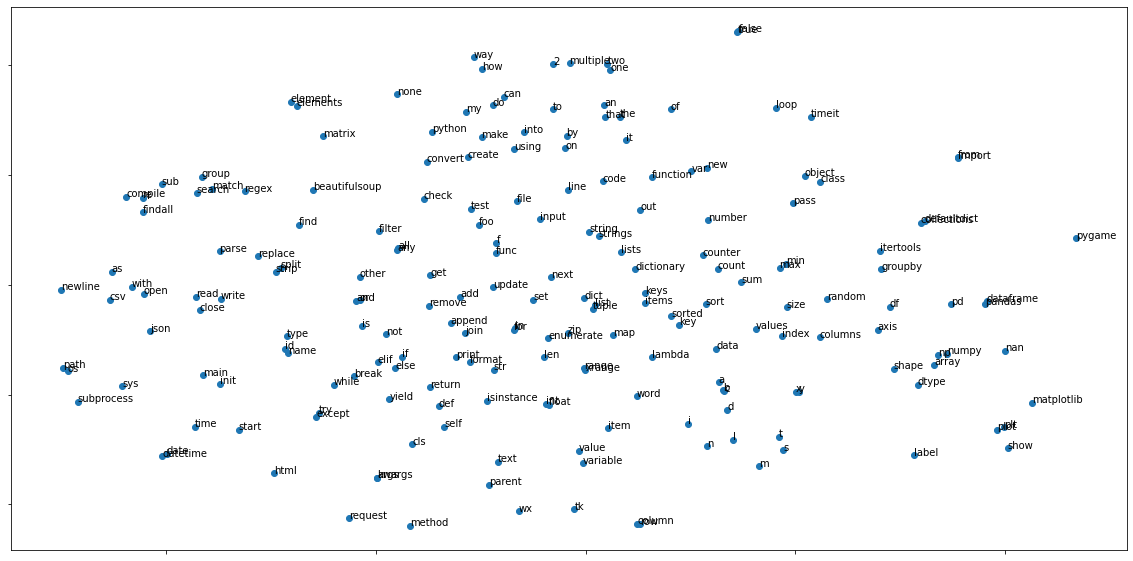

<Figure size 432x288 with 0 Axes>

In [ ]:
sorted_by_word_count = {k: v for k, v in sorted(tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True)}

wanted_words = []
count = 0
for word, freq in sorted_by_word_count.items():
    if count<200:
        wanted_words.append(word)
        count += 1
    else:
        break

wanted_vocab = dict((k, word_vectors.vocab[k]) for k in wanted_words if k in word_vectors.vocab)


X = model[wanted_vocab] # X is an array of word vectors, each vector containing 150 tokens
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
Y = tsne_model.fit_transform(X)


fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(Y[:, 0], Y[:, 1])
words = list(wanted_vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))


ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks

plt.show()
plt.savefig('question-tsne-output.png')
plt.clf()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


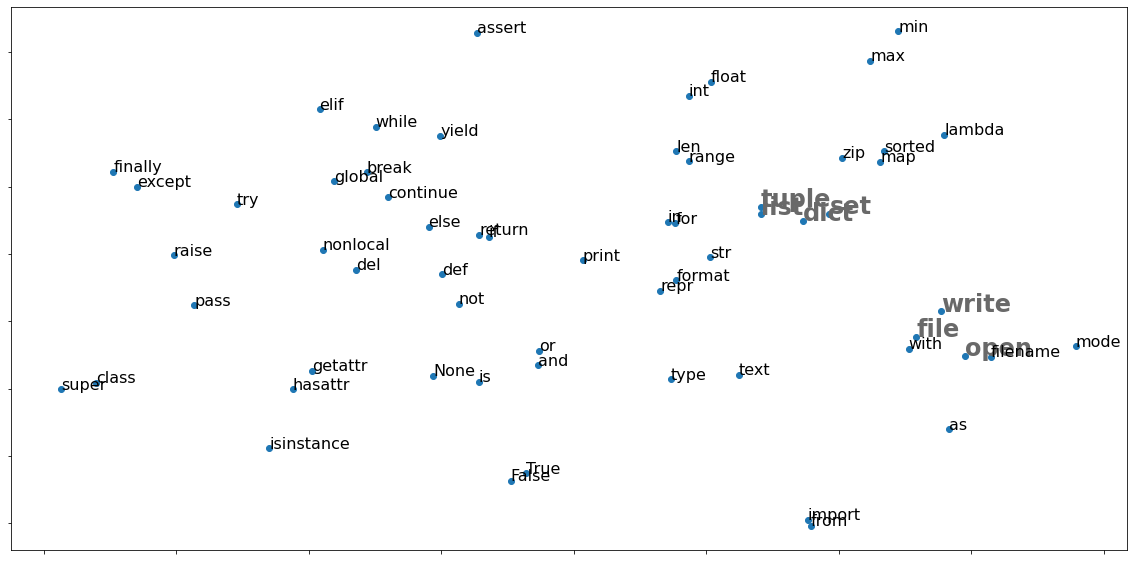

<Figure size 432x288 with 0 Axes>

In [ ]:
top_words = ['with', 'open', 'filename', 'mode', 'as', 'file', 'file', 'write', 'text', 'len', 'print', 'format', 'isinstance', 'str', 'int',
         'int', 'range', 'list', 'super', 'set', 'dict', 'getattr', 'hasattr', 'type', 'float', 'enumarate', 'sorted', 'max',
         'repr', 'zip', 'tuple', 'map', 'min', 'False',	'class',	'finally',	'is',	'return', 'None',	'continue',	'for',	'lambda',	'try',
'True',	'def',	'from',	'nonlocal',	'while','and',	'del',	'global',	'not',	'with', 'as',	'elif',	'if',	'or',	'yield',
'assert',	'else',	'import',	'pass', 'break',	'except',	'in',	'raise']

wanted_vocab = dict((k, word_vectors.vocab[k]) for k in top_words if k in word_vectors.vocab)


X = model[wanted_vocab] # X is an array of word vectors, each vector containing 150 tokens
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
Y = tsne_model.fit_transform(X)


fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(Y[:, 0], Y[:, 1])
words = list(wanted_vocab)
for i, word in enumerate(words):
    # if word in ['file']:
    #   plt.annotate(word, xy=(Y[i, 0], Y[i, 1]), size=24, color='gold', weight='bold')
    # elif word in ['mode', 'as', 'file', 'write']:
    #   plt.annotate(word, xy=(Y[i, 0], Y[i, 1]), size=24, color='green', weight='bold')
    if word in ['file', 'open', 'write', 'list', 'set', 'dict', 'tuple']:
      plt.annotate(word, xy=(Y[i, 0], Y[i, 1]), size=24, color='dimgrey', weight='bold')
    else:
      plt.annotate(word, xy=(Y[i, 0], Y[i, 1]), size=16)


ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks

plt.show()
fig.savefig('code-tsne-output.png')
plt.clf()

In [ ]:
top_words = ['with', 'open', 'filename', 'mode', 'as', 'file', 'file', 'write', 'text', 'len', 'print', 'format', 'isinstance', 'str', 'int',
         'int', 'range', 'list', 'super', 'set', 'dict', 'getattr', 'hasattr', 'type', 'float', 'enumarate', 'sorted', 'max',
         'repr', 'zip', 'tuple', 'map', 'min', 'False',	'class',	'finally',	'is',	'return', 'None',	'continue',	'for',	'lambda',	'try',
'True',	'def',	'from',	'nonlocal',	'while','and',	'del',	'global',	'not',	'with', 'as',	'elif',	'if',	'or',	'yield',
'assert',	'else',	'import',	'pass', 'break',	'except',	'in',	'raise']

len(top_words)

66